# TensorRT

Torch-TensorRT is a new integration of PyTorch with NVIDIA TensorRT, which accelerates the inference with one line of code. 

Here I wanted to test whether we can speed up inference of our Unet using Torch-TensorRT.

Torch-TensorRT can be used to speed up inference. This is useful when performing inference in real-time settings.

## Docker container

I decided to test TensorRT using docker containers. The NVIDIA PyTorch container contains `torch_tensorrt` that we can use to test tensorrt.

https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch/tags


### Install docker

Follow the steps here to install docker : https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html

Whatever you do, don't use snap to install docker.

You should be able to run this command if all goes well, and get the nvidia-smi output.

```
sudo docker run --rm --gpus all nvidia/cuda:11.6.2-base-ubuntu20.04 nvidia-smi
```

## Run a docker container with pytorch

```
sudo docker run --gpus all -it --rm  nvcr.io/nvidia/pytorch:22.11-py3
```

This download the NVIDIA PyTorch docker container. 

The NVIDIA PyTorch Container is optimized for use with NVIDIA GPUs, and contains the following software for GPU acceleration:

CUDA
cuBLAS
NVIDIA cuDNN
NVIDIA NCCL (optimized for NVLink)
RAPIDS
NVIDIA Data Loading Library (DALI)
TensorRT
Torch-TensorRT

See /workspace/README.md inside the container for information on getting started and customizing your PyTorch image.


You might want to pull in data and model descriptions from locations outside the container for use by PyTorch. To accomplish this, the easiest method is to mount one or more host directories as Docker bind mounts. For example:

docker run --gpus all -it --rm -v local_dir:/home/kevin  nvcr.io/nvidia/pytorch:22.11-py3


In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask
from datetime import datetime
import matplotlib.pyplot as plt
from unetTracker.utils import label_video
import torch
import pickle

/home/kevin/trt/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/")

Project directory: /home/kevin/Documents/trackingProjects/faceTrack
Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'unet_features': [64, 128, 256, 512], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'normalization_values': {'means': [0.5110162496566772, 0.4608974754810333, 0.4772901237010956], 'stds': [0.2727729380130768, 0.2578601539134979, 0.256255567073822]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


In [3]:
TRAIN_IMAGE_DIR = os.path.join(project.dataset_dir,"train_images")
TRAIN_MASK_DIR =  os.path.join(project.dataset_dir,"train_masks")
TRAIN_COORDINATE_DIR = os.path.join(project.dataset_dir,"train_coordinates")
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")

DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")) 
BATCH_SIZE = 2
NUM_WORKERS = 4
PIN_MEMORY=False
print(DEVICE)

fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

cuda
Loading valTransform from /home/kevin/Documents/trackingProjects/faceTrack/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.5110162496566772, 0.4608974754810333, 0.4772901237010956], std=[0.2727729380130768, 0.2578601539134979, 0.256255567073822], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [4]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform) 
trainDataset = UNetDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR,TRAIN_COORDINATE_DIR, transform=valTransform) # use same transform as for val
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None)

valLoader = DataLoader(valDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)
trainLoader = DataLoader(trainDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)

In [5]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

Let's get an item from the validation dataset

In [6]:
imageIndex=1
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

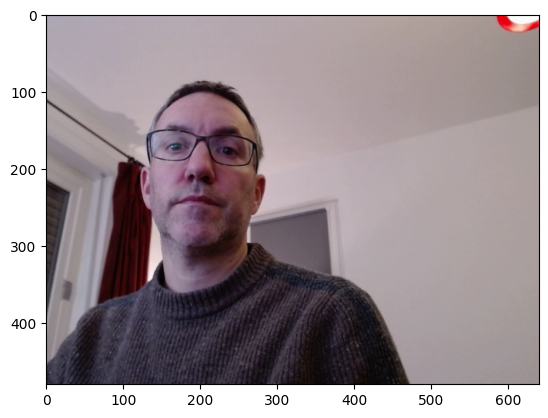

In [7]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [8]:
cDetector = CoordinatesFromSegmentationMask()

In [9]:
def check_accuracy(model,loader,device):

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    num_mask = 0
    num_mask_detected = 0
    num_detected = 0
    sum_distance = 0

    model.eval()
    
    start_time = datetime.now()
    with torch.no_grad():
        for x,y,c in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            output = torch.sigmoid(model(x))
            preds = (output > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2*(preds * y).sum() / ((preds+y).sum() + 1e-8)) # work only for binary

            # proportion of the mask detected
            num_mask += y.sum()
            num_mask_detected += preds[y==1.0].sum()
            num_detected += preds.sum()

            # distance between predicted coordinates and labelled coordinates
            output = output.detach().cpu().numpy()
            pred_coords = cDetector.detect(output)

            sum_distance+= np.nanmean(np.sqrt(((pred_coords[:,:,0:2] - c.numpy())**2).sum(axis=2)))
            # we acutally do a mean of the error for the different objects in a batch

    end_time = datetime.now()
    duration = end_time-start_time

    print(f"Total duration: {duration.total_seconds()} sec")
    print(f"Mean time per batch: {(duration/len(loader)).total_seconds()} sec")
    print(f"Accuracy: {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader):.2f}")
    print(f"Mask pixels detected: {num_mask_detected/num_mask*100:.2f}%")
    print(f"False positives: {(num_detected-num_mask_detected)/num_detected*100:.2f}%")
    print(f"Mean error (distance in pixels): {sum_distance/len(loader)}")
    a = model.train()     

We can use our function to get an idea of the speed.

In [10]:
check_accuracy(model,valLoader,DEVICE)

Total duration: 5.564029 sec
Mean time per batch: 0.104982 sec
Accuracy: 99.96
Dice score: 0.82
Mask pixels detected: 81.91%
False positives: 17.73%
Mean error (distance in pixels): 4.662039443230039


In [13]:
x,y,c = next(iter(valLoader))
x.shape

torch.Size([2, 3, 480, 640])

In [15]:
model.eval()
with torch.no_grad():
    out = model(x.to(DEVICE))

TorchScript records its definitions in an Intermediate Representation (or IR), commonly referred to in Deep learning as a graph. 
We can examine the graph with the .graph property:

In [25]:
traced_model = torch.jit.trace(model, torch.rand(2,3,480,640).to(DEVICE))

In [22]:
check_accuracy(traced_model,valLoader,DEVICE)

Total duration: 5.257511 sec
Mean time per batch: 0.099198 sec
Accuracy: 99.96
Dice score: 0.82
Mask pixels detected: 81.91%
False positives: 17.73%
Mean error (distance in pixels): 4.662039443230039


In [28]:
import torch_tensorrt

FileNotFoundError: Could not find libnvinfer.so.8
  Search paths: ['/usr/local/cuda/lib64', '/home/kevin/trt/lib/python3.8/site-packages/cv2/../../lib64', '/usr/local/cuda-10.1/lib64', '/home/kevin/catkin_ws/devel/lib', '/opt/ros/noetic/lib', '/usr/lib/x86_64-linux-gnu']

In [27]:
trt_ts_module = torch_tensorrt.compile(traced_model,
    inputs = [torch.rand(2,3,480,640).to(DEVICE), # Provide example tensor for input shape or...
        torch_tensorrt.Input( # Specify input object with shape and dtype
            min_shape=[1, 3, 480, 640],
            opt_shape=[2, 3, 480, 640],
            max_shape=[3, 3, 480, 640],
            # For static size shape=[1, 3, 224, 224]
            dtype=torch.half) # Datatype of input tensor. Allowed options torch.(float|half|int8|int32|bool)
    ],
    enabled_precisions = {torch.half}) # Run with FP16)

result = trt_ts_module(x.to(DEVICE)) # run inference
#torch.jit.save(trt_ts_module, "trt_torchscript_module.ts") # save the TRT embedded Torchscript

FileNotFoundError: Could not find libnvinfer.so.8
  Search paths: ['/usr/local/cuda/lib64', '/home/kevin/trt/lib/python3.8/site-packages/cv2/../../lib64', '/usr/local/cuda-10.1/lib64', '/home/kevin/catkin_ws/devel/lib', '/opt/ros/noetic/lib', '/usr/lib/x86_64-linux-gnu']